# Total Market Cap to GDP Ratio

This notebook is looking at the total US market cap (via Wilshire 5000 index) to US GDP ratio.

In part this is an exercise in accessing and manipulating financial data using Python.

In [166]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import datetime
import requests_cache
from plotnine import ggplot, geom_point, aes, geom_boxplot, geom_rect, scale_x_discrete, themes

In [2]:
# We don't need to continually refresh this data, so leveraging the built-in caching capabilities.

expire_after = datetime.timedelta(days=3)
session = requests_cache.CachedSession(cache_name='cache', backend='sqlite', expire_after=expire_after)

In [146]:
def fetch_tmc_gdp_df(start: datetime = None, end: datetime = None) -> pd.DataFrame:
    """
    Fetches data TMC/GDP ratio from FRED.
    
    Parameters:
    start (datetime): Start of date range for pulling data.
    end (datetime): End of date range for pulling data.
    
    Returns:
    A Pandas dataframe with total market cap, gdp, ratio, date stamp, and month stamp.
    """
    
    if start is None:
        start = datetime.datetime(2000,1,1)
    if end is None:
        end = datetime.datetime.combine(datetime.date.today(), datetime.time(0))
        
    tmc = web.DataReader('WILL5000PRFC', 'fred', start, end, session=session)

    # Temporarily fill in missing values
#     tmc.loc[datetime.datetime(2020,3,26), 'WILL5000PRFC'] = 26014.11
    
    gdp = web.DataReader('GDP', 'fred', start, end, session=session)

    df = pd.merge(tmc, gdp, on='DATE', how='left').reset_index()
    df = df.fillna(method='pad')
    df['RATIO'] = df['WILL5000PRFC'] * 100 / df['GDP']
    df = df.dropna()
    df['MONTH'] = [str(x)[:7] for x in df['DATE']]
    
    return df
    

In [156]:
def fetch_usrecd(start: datetime = None, end: datetime = None) -> pd.DataFrame:
    """
    Fetches recession data from FRED
    
    Parameters:
    start (datetime): Start of date range for pulling data.
    end (datetime): End of date range for pulling data.
    
    Returns:
    A Pandas dataframe with total market cap, gdp, ratio, date stamp, and month stamp.
    """
    
    if start is None:
        start = datetime.datetime(2000,1,1)
    if end is None:
        end = datetime.datetime.combine(datetime.date.today(), datetime.time(0))
    
    df = web.DataReader('USRECD', 'fred', start, end, session=session)
    
    df = df.diff()
    
    df = df[df['USRECD'] != 0].dropna()
    
    ## started in a recession
    if df['USRECD'].values[0] < 0:
        df.loc[start, 'USRECD'] = 1

    ## ended in a recession
    if df['USRECD'].values[0] > 0:
        df.loc[end, 'USRECD'] = -1
    
    df = df.reset_index()
    
    df['MONTH'] = [str(x)[:7] for x in df['DATE']]
    
    return pd.DataFrame({ 'start' : df[df['USRECD'] == 1].reset_index(drop=True)['MONTH'],
                          'end'   : df[df['USRECD'] == -1].reset_index(drop=True)['MONTH'] })


Fetch the dataframes

In [159]:
my_ratio_df = fetch_tmc_gdp_df()
my_rec = fetch_usrecd()

Example data from the end of the data frame.

In [149]:
my_ratio_df.tail()

,DATE,WILL5000PRFC,GDP,RATIO,MONTH
5336,2020-06-16,31871.97,21534.907,148.001429,2020-06
5337,2020-06-17,31728.74,21534.907,147.336322,2020-06
5338,2020-06-18,31772.42,21534.907,147.539156,2020-06
5339,2020-06-19,31612.06,21534.907,146.794504,2020-06
5340,2020-06-22,31821.33,21534.907,147.766275,2020-06


Summary statistics for the tmc/gdp ratio.

In [150]:
my_ratio_df[['RATIO']].describe(percentiles=[.1, .25, .5, .75, .9])

,RATIO
count,5081.000000
mean,102.973446
std,22.119981
min,47.646029
10%,76.863456
25%,88.249715
50%,98.598406
75%,118.212576
90%,137.668341
max,160.362661


Plotting the tmc/gdp ratio starting in 2010, near the end of the GFC.

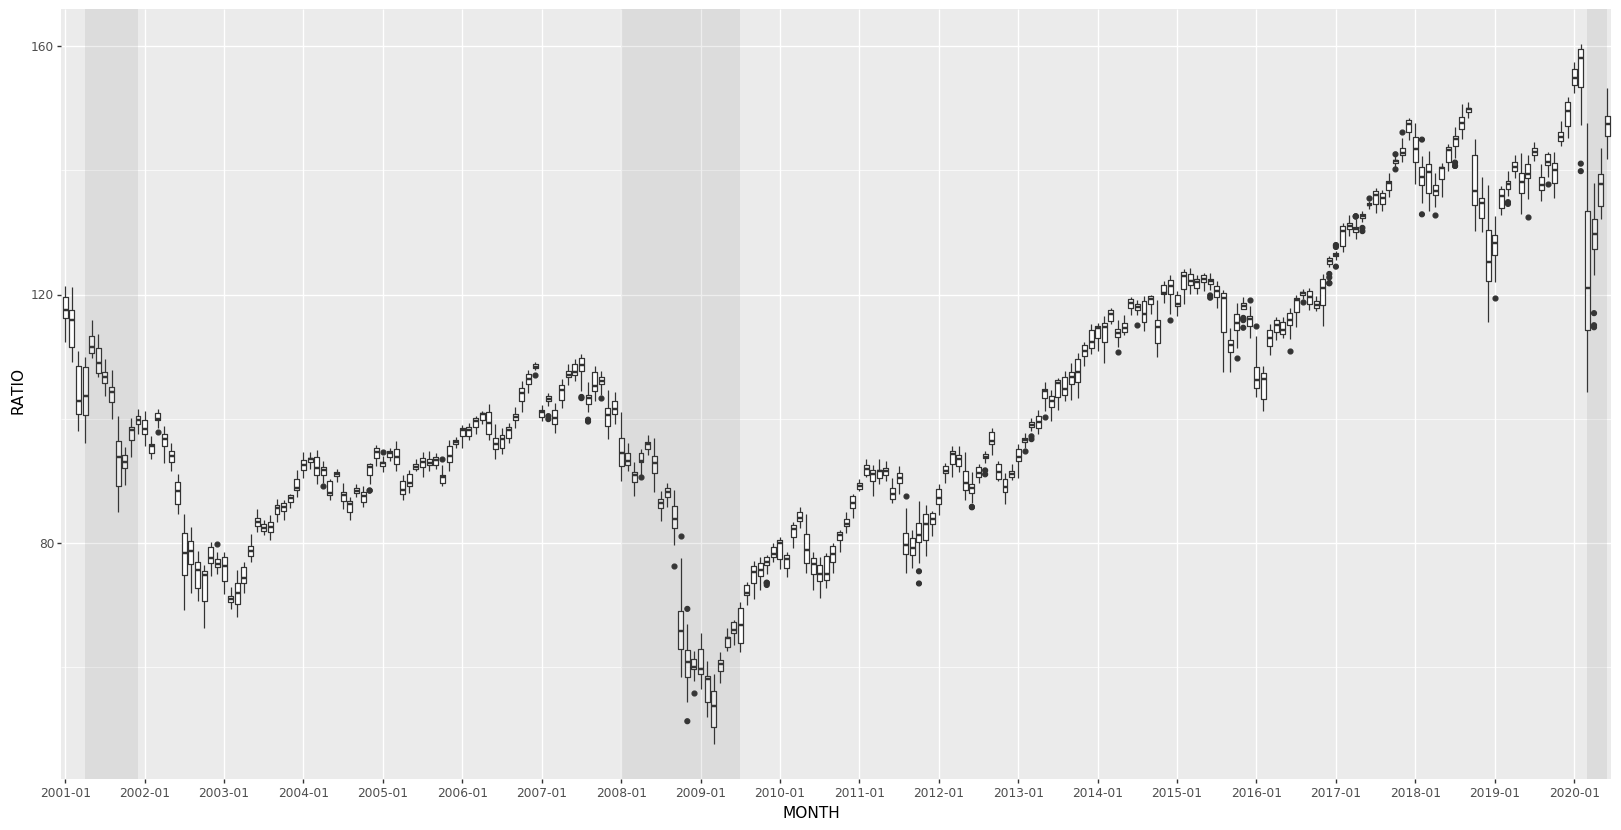

<ggplot: (8773355484992)>


In [168]:
print(ggplot(my_ratio_df.loc[my_ratio_df['MONTH'] > '2000-01'])
     + geom_boxplot(aes(x='factor(MONTH)', y='RATIO'))
     + geom_rect(data=my_rec.loc[my_rec['start'] > '2000-01'], mapping=aes(xmin='start', xmax='end', ymin=-np.inf, ymax=np.inf), alpha=0.1)
     + scale_x_discrete(name='MONTH', breaks=lambda arr: [x for x in arr if x[5:7] == '01'])
     + themes.theme_gray()
     + themes.theme(figure_size=(20,10)))